# Classification Decision Trees

> "An introduction into classification decision trees, specifically looking at how trees make splits based on entropy"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Wes Barnett
- categories: [machinelearning]

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

scikit-learn now comes with a way to plot trees, but I prefer using `graphviz` so here is a quick function to plot a tree, which we monkey-patch into the `DecisionTreeClassifier` and `DecisionTreeRegressor` classes.

In [102]:
def display_tree(self):
    dot_data = tree.export_graphviz(self, out_file=None, filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

DecisionTreeClassifier.plot = display_tree

## Classification

We'll use the Iris dataset as a quick way to discuss classification trees. To learn more about this dataset use `help(load_iris)`.

In [103]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Fitting

Decision trees search over all possible ways to split up features and find the split that is most informative about the target variable. The parent node splits into two child nodes based on this split. From there the children also split in the same manner until all leaves are pure, unless another stopping condition is specified. A leaf is a node that has no children. A pure leaf is a leaf with only one class of items in it.

Classifications trees split using the GINI impurity which is defined as:

$I_{G}(p) = \sum_{i=1}^{J}p_{i}(1-p_{i})$

Here $p_{i}$ is the probability of an item with label $i$ being chosen and $1 - p_{i}$ is the probability of a mistake in categorizing that item. $J$ is the number of classes. Gini reaches zero when all cases in the node fall into a single target category.

Alternatively, one can use information gain to decide where to split, where information gain is defined as the difference in entropy of the parent and the weighted sum of the entropies of the children. Entropy is defined as:

$H_(p) = -\sum_{i=1}^{J}p_{i}\log_{2}(p_{i})$

Let's train a decision tree:

In [104]:
clf = DecisionTreeClassifier(criterion="entropy").fit(X_train, y_train)

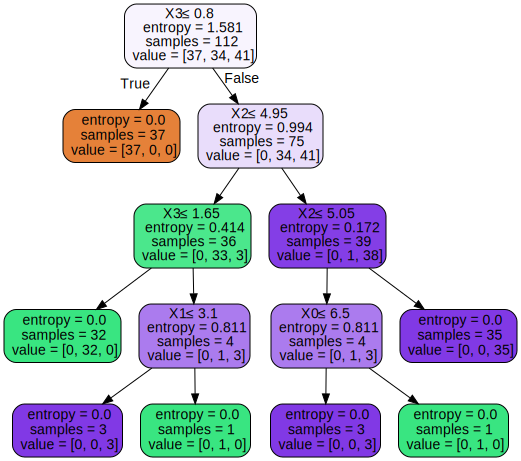

In [105]:
clf.plot()

Here's the training score which indeed shows the tree is perfect at classfying the flowers on the training set. This tends to result in overfitting to the training set.

In [106]:
clf.score(X_train, y_train)

1.0

This is an easy dataset to classify, so the overfitting is not evident here.

In [107]:
clf.score(X_test, y_test)

0.9736842105263158

There are 7 leaves in our tree. Note that the leaves do not have to be depicted at the bottom of the tree in the diagram. A leaf is just a node without any children and could be represented near the top of the tree.

In [108]:
clf.get_n_leaves()

7

### Inference

Now that we have trained our model, we can perform inference.

When inference on new samples is performed, the sample simply is examined with the "rules" created by the feature splits. Starting from the topmost node (the root node) in our example above, if feature three has a value of less than or equal 0.8, go to the left child node; otherwise go to the right. This process continues all the way down until the sample is put into a leaf.

The predicted class is the class in the leaf with the highest probability of that class for that leaf. In other words, simply break down the training samples by class within that leaf and choose the class with the most number of train samples. The probability of choosing that class is simply the number of training samples in that leaf belonging to that class divided by the total number of training samples in that leaf.

Since all of our leafs are pure, the classifier will always give 100% for its predictions. We'll rexamine this when we have impure leafs below.

Here are the features for the first test sample. 

In [109]:
X_test[0]

array([5.8, 2.8, 5.1, 2.4])

The path for this sample follows down the right side of the tree. Note that features are zero-indexed.

Root node: Is 2.4 <= 0.8? No, so go right.

Is 5.1 <= 4.95? No, so go right.

Is 5.1 <= 5.05? No, so go right.

That brings it to the leaf on the right with 35 samples, where the 3rd class (index 2) is predicted:

In [110]:
clf.predict([X_test[0]])

array([2])

Again, the probability is 100% since there are no training samples in that leaf from the other two classes. In the plot the node is colored dark purple. For this tree purple represents the 3rd class and the darker the shade the more probable it is.

In [111]:
clf.predict_proba([X_test[0]])

array([[0., 0., 1.]])

## Pruning

One way to prevent overfitting is the pre-prune the tree by specifying the maximum depth and/or maximum number of leaves. Here we set the maximum depth to 3.

In [112]:
clf = DecisionTreeClassifier(max_depth=3, random_state=0, criterion="entropy").fit(X_train, y_train)

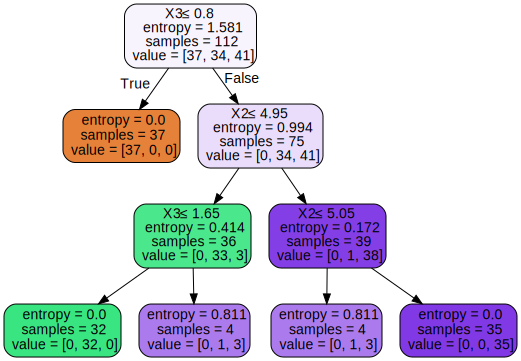

In [113]:
clf.plot()

In [114]:
clf.score(X_train, y_train)

0.9821428571428571

In [115]:
clf.score(X_test, y_test)

0.9736842105263158

Here is a sample where we are only 75% sure that it is class 2, since only 3 of the 4 samples in its leaf are class 2.

In [116]:
clf.predict([X_test[20]])

array([2])

In [117]:
clf.predict_proba([X_test[20]])

array([[0.  , 0.25, 0.75]])

## How a classification tree determines where to split

Let's talk a little bit more about how trees use entropy (or alternatively Gini) to determine splits.

Information gain is calculated by cycling through all possible splits in the training set. Practically this is the process:

1. Select the first feature.
2. Pick the halfway point between the first sample and the second sample.
3. Calculate the entropy of the two child nodes if a split is made at that point.
4. Repeat steps 2 and 3 for all midpoints for this feature.
5. Go back to step 1 and repeat for all features.

At the end, pick the feature and split that has the lowest sum entropy for the two child nodes.

Again, information gain is the difference in entropy of the parent node and the summation of entropies of the two child nodes. Since the entropy of the parent node is the same for each potential split that we try, we only need to calculate the entropies of the child nodes for a split and find the split that minimizes that since that will maximize the information gained.

Here's a tree with a max depth of 1 using entropy to split:

In [118]:
clf = DecisionTreeClassifier(random_state=42, max_depth=1, criterion="entropy").fit(X_train, y_train)

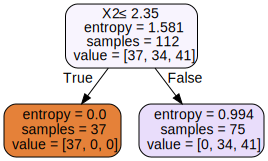

In [119]:
clf.plot()

Let's implement our entropy calculation. This takes a list of targets and calculates the entropy for that node.

In [120]:
from collections import Counter

def entropy(values):
    total = values.shape[0]
    c = Counter(values)
    
    if total == 0:
        return 0
    
    s = 0
    for x in c.values():
        p = x/total
        s += p * np.log2(p)
        
    return -s

Here's our original list of targets:

In [121]:
y_train

array([1, 1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2,
       1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 0, 2, 1, 0, 1, 2, 1,
       0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2,
       2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 0, 0, 2, 0,
       2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1,
       2, 0])

Here's the associated entropy which matches above. This is the entropy of the root node.

In [122]:
entropy(y_train)

1.5807197138422104

Now let's get the entropes of the child nodes for the split that was found. In this case it was feature 3 with the split at 0.8.

In [123]:
feat = 3
x = 0.8

Here are the samples that went into the left node. As you can see all of them are of class `0`. There is no entropy associated with this node - the node is pure.

In [124]:
left = y_train[X_train[:,feat] <= x]
left

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [125]:
entropy(left)

-0.0

Here are the samples that went into the right node:

In [126]:
right = y_train[X_train[:,feat] > x]
right

array([1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 1, 2])

In [127]:
entropy(right)

0.993707106604508

Now we need the cycle through each feature, and then cycle through each possible split.

In [128]:
import math

def calc_entropies(X, y):
    
    n = y.shape[0]
    m = X.shape[1]
    min_ents = np.zeros(m)
    min_splits = np.zeros(m)

    for feat in range(m):
    
        # Use set to remove dups; sort it to get halfway points
        points = sorted(list(set(X[:,feat])))
        
        splits = [(points[i-1]+points[i])/2. for i in range(1, len(points))]
        entropies = []
        
        for x in splits:
        
            l = y_train[X_train[:,feat] <= x]
            r = y_train[X_train[:,feat] > x]
        
            e = (l.shape[0]*entropy(l) + r.shape[0]*entropy(r)) / n
            entropies.append(e)

        feat_min_ent = np.argmin(entropies)
        min_ents[feat] = entropies[feat_min_ent]
        min_splits[feat] = splits[feat_min_ent]
        
    min_feat = np.argmin(min_ents)
            
    return min_feat, min_splits[min_feat], min_ents[min_feat]

In [129]:
calc_entropies(X_train, y_train)

(2, 2.35, 0.6654288660298044)

Note that in this example splitting feature 3 at 0.8 gives the same entropy as the above split. `np.argmin` returns the argument of the first minimum in the case of a tie.

## Regression

I'll cover decision tree regression in another post soon.